<a href="https://colab.research.google.com/github/RomainHugues/CitySat_public/blob/master/satellite_system_simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# (c) Romain Hugues 2019

In [0]:
import pandas

!pip install geopandas
import geopandas

import numpy
import os

!pip install pyorbital
from pyorbital.orbital import Orbital
from pyorbital import astronomy

from datetime import datetime, timedelta
import shapely
import random
import time

from sklearn.neighbors import NearestNeighbors

!pip install folium
import folium

from matplotlib import pyplot as plt

from google.colab import drive

# Satellite system simulator

We have a satellite orbiting around the Earth and whose mission is to observe it

Design the ground segment in order to optimize the mission performance


In [0]:
class Satellite:

    def __init__(self):

        self.name = "LANDSAT-8"
        # https://pyorbital.readthedocs.io/en/latest/#
        # position = [lon, lat, alt]
        self.position = [0.,0.,0.]
        self.sza = None
        self.max_sza = 60
        self.datetime = None
        self.orb = Orbital(self.name)

        self.cities = None
        self.cities_position_array = None
        self.neigh = NearestNeighbors(n_neighbors=1, algorithm='kd_tree')
        self.country_geometry = None


    def set_cities(self):

        # Load city data as pandas dataframe
        city_db = Cities()
        self.cities = city_db.load()

        # Set-up KD-tree with cities location
        self.cities_position_array = numpy.stack([self.cities.lng.to_numpy(), self.cities.lat.to_numpy()]).T
        self.neigh.fit(self.cities_position_array) 

    def set_country(self, country):

        # Load countries polygons
        countries_db = Countries()
        countries_db.load()

        self.country_geometry = countries_db.countries[countries_db.countries.ADMIN == country].geometry

    def set_datetime(self, new_date):

        self.datetime = new_date

    def compute_position(self):

        self.position = self.orb.get_lonlatalt(self.datetime)
        self.sza = astronomy.sun_zenith_angle(self.datetime, self.position[0], self.position[1])

    def compute_footprint(self, payload):

        angular_gsd = payload.ground_sampling_distance / (1850 * 60)

        d_lon = 0.5 * angular_gsd * payload.swath_width / numpy.cos(self.position[1]*numpy.pi / 180)
        d_lat = 0.5 * angular_gsd * payload.lines_freq

        self.image = shapely.geometry.Polygon([(self.position[0]-d_lon,self.position[1]-d_lat),
                                        (self.position[0]-d_lon,self.position[1]+d_lat),
                                        (self.position[0]+d_lon,self.position[1]+d_lat),
                                        (self.position[0]+d_lon,self.position[1]-d_lat),
                                        (self.position[0]-d_lon,self.position[1]-d_lat),
                                        ])

    def check_acquisition(self, 
                          mode='random', 
                          random_acquisition_proba=1e-3):

        # Day condition check
        if self.sza > self.max_sza:
            
            need_acquisition = False
            complement_info = 'Night'

        else:

            if mode is 'random':
                
                need_acquisition = random.random() < random_acquisition_proba
                complement_info = 'Random'

            elif mode is 'city':
                
                # Looking for closest city in list
                distance, index = self.neigh.kneighbors(numpy.array([self.position[:-1]]))
                closest_city = self.cities.iloc[index[0,0]]

                # Checking if city is included in image footprint

                point = shapely.geometry.Point(float(closest_city.lng),float(closest_city.lat))

                need_acquisition = self.image.contains(point)
                complement_info = closest_city.city

            elif mode is 'country':

                gdf = geopandas.GeoDataFrame(geometry=[sat.image], index=['image'])

                need_acquisition = False
                complement_info = 'Null'

                for index, geom in self.country_geometry.items():
                    # Fix bug when multiple items in geometry
                    if gdf.within(geom).any():
                        need_acquisition = True
                        complement_info = str(index)

            else:

                need_acquisition = False
                complement_info = 'Wrong mode'
        
        return need_acquisition, complement_info

    
    def check_download(self, stations_position, max_elevation=80):

        # Compute incidence angle between satellite and station position
        
        can_download = False

        azi = numpy.zeros(len(stations_position))
        ele = numpy.zeros(len(stations_position))
        can_download = numpy.zeros(len(stations_position))

        for i in range(len(stations_position)):

            azi[i], ele[i] = self.orb.get_observer_look(self.datetime, stations_position[i][0], stations_position[i][1], stations_position[i][2])

            if ele[i] > (90 - max_elevation):
                can_download[i] = True

        i_best_ele = numpy.argmax(ele)

        best_ele = ele[i_best_ele]
        best_can_download = can_download[i_best_ele]

        return best_can_download, best_ele



In [0]:
class Cities:
# https://simplemaps.com/data/world-cities

    def __init__(self):

        self.loaded = False

    def load(self):
        
        if not os.path.exists('/content/worldcities.csv'):
            
            drive.mount('/content/gdrive')
            !cp /content/gdrive/My\ Drive/data/simplemaps_worldcities_basicv1.5.zip /content/sample_data/

            !unzip -o /content/sample_data/simplemaps_worldcities_basicv1.5.zip
            
            self.loaded = True

        city_list = pandas.read_csv('/content/worldcities.csv')

        return city_list


In [0]:
class Countries:
# https://datahub.io/core/geo-countries#data

    def __init__(self):

        self.countries = None

    def load(self):

        if not os.path.exists('/content/sample_data/countries.geojson'):

            drive.mount('/content/gdrive')
            !cp /content/gdrive/My\ Drive/data/countries.geojson /content/sample_data/

            !unzip -o /content/sample_data/countries.geojson
                    
        self.countries = geopandas.read_file('/content/sample_data/countries.geojson')



In [0]:
class Payload:

    def __init__(self, ground_sampling_distance):
        
        # Ground Sampling Distance [m]
        self.ground_sampling_distance = ground_sampling_distance
        # Swath width [px]
        self.swath_width = int(30e5 / self.ground_sampling_distance)
        # Lines frequency [px/s]
        self.lines_freq = int(6666. / self.ground_sampling_distance) 
        # N bands
        self.n_bands = 3
        # Coding after compression [bit/px]
        self.coding = 4

        # Max Memory [bits]
        self.max_memory = 4 * 2**40
        # Memory Level [bits]
        self.memory = 0

        # Size of Acquisition [bit /s]
        self.acquisition_size = self.lines_freq * self.n_bands * self.swath_width * self.coding
        # Min Acquisition duration [s]
        self.min_acquisition_duration = 30
        # Acqusition duration level [s]
        self.acquisition_duration = 0

        # Payload temperature [270 + K]
        self.min_temperature = 0
        self.temperature = self.min_temperature
        # Cooling rate [K /s]
        self.cooling_rate = 1
        # Warming rate [K / s]
        self.warming_rate = 0.25
        # Max temperature [K]
        self.max_temperature = 50

        # Acquisition flags
        self.keep_acquisition = False
        self.stop_acquisition = False

        # ITM download rate [b / s]
        self.download_rate = 1 * 2**30

    def warm(self):
        # Able to acquire : warming up
        self.acquisition_duration += 1
        self.temperature += self.warming_rate
        self.memory += self.acquisition_size

        return True

    def cool(self):
        # Cooling down
        self.acquisition_duration = 0
        self.temperature -= self.cooling_rate
        self.temperature = max(self.temperature, self.min_temperature)

        return False

    def acquire(self, need_acquisition):

        # Check ability to acquire wrt instruments temperature and memory
        self.stop_acquisition_flag = self.temperature >= self.max_temperature 
        self.stop_memory_flag = self.memory >= self.max_memory

        if self.stop_acquisition_flag or self.stop_memory_flag:
            self.stop_acquisition = True
        else:
            self.stop_acquisition = False

        if need_acquisition:

            if self.stop_acquisition:

                # Not able to acquire : cooling down
                acquisition_ok = self.cool()

            else:

                # Able to acquire : warming up
                acquisition_ok = self.warm()

        else:
            
            if self.keep_acquisition:
                
                # Have to acquire : warming up
                acquisition_ok = self.warm()

            else:

                # Do not have to acquire : cooling down
                acquisition_ok = self.cool()

        # Update keep_acquisition flag
        if self.acquisition_duration < self.min_acquisition_duration and self.acquisition_duration > 0:
            self.keep_acquisition = True
        else:
            self.keep_acquisition = False

        return acquisition_ok

    def download(self, can_download, ground_segment):

        if can_download:
            if self.memory >= 0:
                # Download necessary

                archive_ok = ground_segment.store_data(self.download_rate)

                if archive_ok:
                    # Do transfer
                    self.memory -= self.download_rate
                    download_ok = True
                else:
                    # No transfer
                    download_ok = False
            else:
                # Download not necessary
                download_ok = False
        else:
            download_ok = False

        return download_ok, ground_segment



In [0]:
class GroundSegment:

    def __init__(self, stations_position):

        # Max archive size (single archive connected to all stations) [b]
        self.max_archive = 40 * 2**50
        # Archive_size (initial value) [b]
        self.archive_size = 0
        # Stations position [Lon, Lat, Alt]
        self.stations_position = stations_position

    def store_data(self, data_size):
        
        if self.archive_size <= self.max_archive:
            self.archive_size += data_size 
            archive_ok = True
        else:
            archive_ok = False
        
        return archive_ok
    

In [0]:
class Scenario:

    def __init__(self,time_begin, time_delta):

        self.time_begin = time_begin
        self.time_end = self.time_begin + time_delta
        self.current_time = 0
        self.duration = self.time_end - self.time_begin
        self.time_delta_seconds = self.duration.total_seconds()


In [0]:
class Display:

    def __init__(self, period):

        self.start = 0
        self.time_epoch = 0
        self.simulation_speedup = 0
        
        self.memory_ratio = 0
        self.temperature_ratio = 0
        self.archive_ratio = 0

        self.period = period
            
    def start_epoch(self):

        self.start = time.time()

    def end_epoch(self, epoch):

        self.time_epoch = time.time() - self.start
        self.simulation_speedup = round(epoch / self.time_epoch,1 )

    def compute_ratio(self, payload, ground_segment):

        self.memory_ratio = round(100 * payload.memory / payload.max_memory,1)
        self.temperature_ratio = round(100 * payload.temperature / payload.max_temperature, 1)
        self.archive_ratio = round(100 *  ground_segment.archive_size / ground_segment.max_archive, 5)

    def update_map(self):

        return 0

# Main Script

In [0]:
# Satellite instance
sat = Satellite()

acq_mode = 'city'

if acq_mode is 'country':
    sat.set_country('Russia')
elif acq_mode is 'city':
    sat.set_cities()

# Payload instance
ground_sampling_distance = 20
payload = Payload(ground_sampling_distance)

# Ground Segment instance

# Svalbard
# stations_position = [[16.,78.,0.]]

# Middle of nowhere
# stations_position = [[0.,0.,0.]]

# Svalbard + Réunion + Paris
stations_position = [[16.,78.,0.],
                     [55.,-21.,0.],
                     [0.,50.,0.]]

ground_segment = GroundSegment(stations_position)

# Scenario instance
time_begin = datetime(year=2017,month=6,day=1, hour=12, minute=0, second=0)
time_delta = timedelta(days=1)
scenario = Scenario(time_begin= time_begin,
                    time_delta = time_delta) 

# Display instance
display = Display(period=3*3600)

# Covered Area

mission_info = []
mission_geometry = []
mission_geometry_index = []
position = []

display.start_epoch()

for second in range(int(scenario.time_delta_seconds)):

    # Date
    new_date = scenario.time_begin + timedelta(seconds=second)
    sat.set_datetime(new_date)

    # Satellite position and SZA
    sat.compute_position()

    # Image footprint polygon [Lon,Lat]

    sat.compute_footprint(payload)
    
    # Check if it is necessary to acquire scene
    need_acquisition, complement_info = sat.check_acquisition(mode=acq_mode)
    
    # Check if can download data to ground segment
    can_download, ele = sat.check_download(ground_segment.stations_position)

    # Acquisition simulation
    acquisition_ok = payload.acquire(need_acquisition)

    if acquisition_ok:
        # Update mission_geometry
        mission_geometry.append(sat.image)
        mission_geometry_index.append(str(second))

    # Download simulation
    download_ok, ground_segment = payload.download(can_download, ground_segment)

    # Simulation parameters
    display.end_epoch(second)
    display.compute_ratio(payload, ground_segment)

    missed_acquisition = need_acquisition and not acquisition_ok

    mission_info.append([new_date,sat.position,sat.sza, len(mission_geometry_index), ele,
                         missed_acquisition, can_download, acquisition_ok, download_ok,
                         display.simulation_speedup, display.memory_ratio, display.temperature_ratio, display.archive_ratio])

    # Text update
    if second % display.period == 0:
        print(new_date, second, display.simulation_speedup)

# Convert data to dataframe
mission_info_df = pandas.DataFrame.from_records(mission_info, columns=['date','position','sza','acquired_images', 'elevation',
                                                                       'missed_acquisition','can_download',
                                                                       'acquisition_flag', 'download_flag',
                                                                       'simu_speedup','memory_ratio','temp_ratio','archive_ratio'])

2017-06-01 12:00:00 0 0.0
2017-06-01 15:00:00 10800 621.7
2017-06-01 18:00:00 21600 620.9
2017-06-01 21:00:00 32400 615.9
2017-06-02 00:00:00 43200 612.5
2017-06-02 03:00:00 54000 610.9
2017-06-02 06:00:00 64800 610.8
2017-06-02 09:00:00 75600 615.1


Text(0.5, 1.0, 'Download ON')

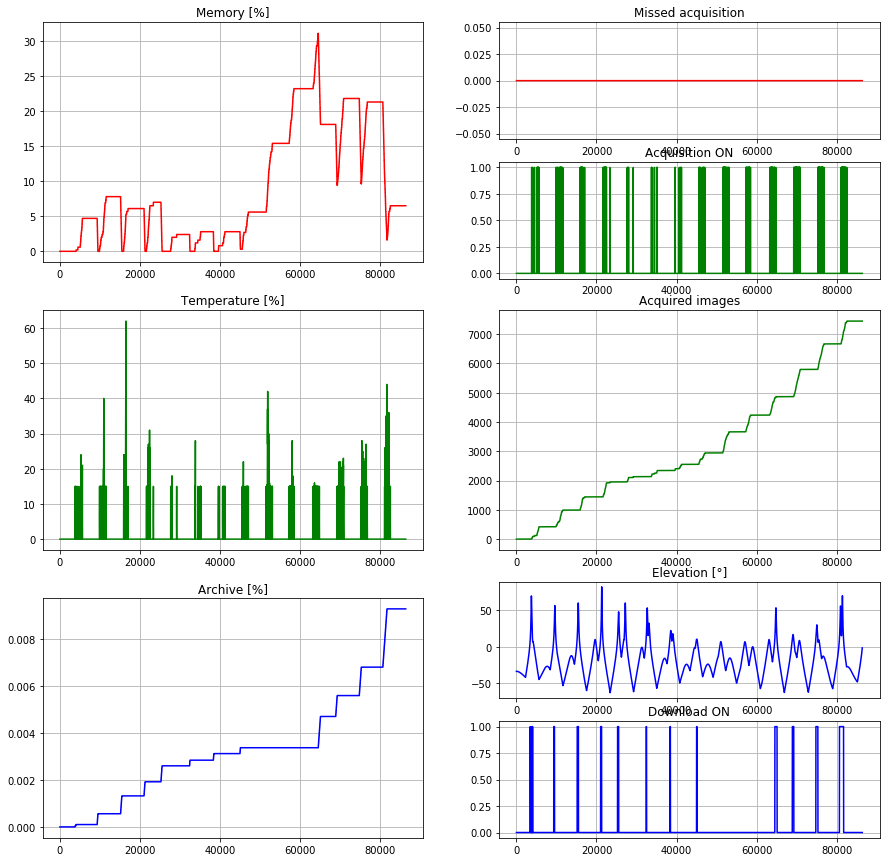

In [0]:
plt.figure(figsize=[15,15])
plt.subplot(3,2,1)
plt.plot(mission_info_df.memory_ratio,color='r')
plt.grid()
plt.title('Memory [%]')

plt.subplot(3,2,3)
plt.plot(mission_info_df.temp_ratio,color='g')
plt.grid()
plt.title('Temperature [%]')

plt.subplot(3,2,5)
plt.plot(mission_info_df.archive_ratio,color='b')
plt.grid()
plt.title('Archive [%]')

plt.subplot(6,2,2)
plt.plot(mission_info_df.missed_acquisition, color='r')
plt.grid()
plt.title('Missed acquisition')

plt.subplot(6,2,4)
plt.plot(mission_info_df.acquisition_flag,color='g')
plt.grid()
plt.title('Acquisition ON')

plt.subplot(3,2,4)
plt.plot(mission_info_df.acquired_images, color='g')
plt.grid()
plt.title('Acquired images')

plt.subplot(6,2,10)
plt.plot(mission_info_df.elevation,color='b')
plt.grid()
plt.title('Elevation [°]')

plt.subplot(6,2,12)
plt.plot(mission_info_df.download_flag,color='b')
plt.grid()
plt.title('Download ON')
